In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import norm

from env_2actions import *

In [2]:
class Actor(nn.Module):
    def __init__(self, input_layer, output_layer):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_layer, 128),       
            # nn.Dropout(p=0.15),              
            nn.ReLU(),                     
            nn.Linear(128, 64),
            # nn.Dropout(p=0.15),  
            nn.ReLU(), 
            nn.Linear(64, output_layer),
            nn.Softmax(dim=-1)               
        )
        
    def forward(self, x):
        return self.net(x)


class Critic(nn.Module):
    def __init__(self, input_layer): #Evaluating so output should be 1, instead of softmax giving probabilities
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_layer, 128512),     
            #nn.Dropout(p=0.15),            
            nn.ReLU(),                    
            nn.Linear(128, 64),
            #nn.Dropout(p=0.15),  
            nn.ReLU(),
            nn.Linear(64, 1)              
        )
        
    def forward(self, x):
        return self.net(x)

In [3]:
# class Actor(nn.Module):
#     def __init__(self, input_layer, output_layer):
#         super().__init__()
        
#         self.net = nn.Sequential(
#             nn.Linear(input_layer,32),
#             nn.PReLU(),
#             nn.Linear(32, 256),       
#             nn.Dropout(p=0.15),              
#             nn.PReLU(),
#             nn.Linear(256, 512),       
#             nn.Dropout(p=0.15),              
#             nn.PReLU(),                       
#             nn.Linear(512, 256),
#             nn.Dropout(p=0.15),  
#             nn.PReLU(),
#             nn.Linear(256, 32),
#             nn.Dropout(p=0.15),  
#             nn.PReLU(),  
#             nn.Linear(32, output_layer),
#             nn.Softmax(dim=-1)            
#         )
        
#     def forward(self, x):
#         return self.net(x)

# class Critic(nn.Module):
#     def __init__(self, input_layer):
#         super().__init__()
        
#         self.net = nn.Sequential(
#             nn.Linear(input_layer,32),
#             nn.PReLU(),
#             nn.Linear(32, 256),       
#             nn.Dropout(p=0.15),              
#             nn.PReLU(),
#             nn.Linear(256, 512),       
#             nn.Dropout(p=0.15),              
#             nn.PReLU(),                       
#             nn.Linear(512, 256),
#             nn.Dropout(p=0.15),  
#             nn.PReLU(),
#             nn.Linear(256, 32),
#             nn.Dropout(p=0.15),  
#             nn.PReLU(),  
#             nn.Linear(32, 1)            
#         )
        
#     def forward(self, x):
#         return self.net(x)

In [4]:

# def select_action(actor,state):
#      with torch.no_grad():
#             probs = actor(state)
#             best_row_idx = probs.argmax()
#             best_actions = actions_list[best_row_idx]  # This will be a tuple like (0, 1, 2, 0, 1)
#             # Convert to a tensor (optional, if needed)
#             best_actions_tensor = torch.tensor(best_actions).view(1,5)
#             return best_row_idx, best_actions_tensor  # Shape: [1, 5]

In [5]:
def episode(train_env, actor, critic, state, states, actions, log_prob_actions, values, rewards, done,episode_reward):
    reward = 0
    state = train_env.reset()
    state_tensor = torch.tensor(state, dtype=torch.float32).view(1, -1)
    GAMMA = 0.99
    for t in range(1,51):
        state_tensor = torch.cat((state_tensor,torch.tensor([[t/50]], dtype=torch.float32)),dim = 1)
        action_pred = actor(state_tensor)
        value_pred = critic(state_tensor)
        dist = distributions.Categorical(action_pred)
        action = dist.sample()
        action_r = actions_list[action.item()]
        action_r = torch.tensor(action_r).view(1,5)
        #action_index, action_r = select_action(actor,state_tensor)
        log_prob_action = dist.log_prob(action)
        reward = immediatecost(action_r, cost_comp_action)
        if is_system_failed(state):
            reward -= 2400
        episode_reward += GAMMA**(t-1)*reward
        if t==50:
            next_state = None
        else:
            next_state, terminated, truncated, observations = train_env.step(state,action_r,t)
            #next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0) if next_state is not None else None
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).view(1, -1) if next_state is not None else None
            #next_s_tensor = torch.cat((next_state_tensor, torch.tensor([[(t+1)/50]], dtype=torch.float32)), dim=1)
        
        states.append(state_tensor)
        actions.append(action)
        log_prob_actions.append(log_prob_action)
        values.append(value_pred)
        #rewards.append(reward)
        rewards.append(reward)
        state = next_state
        state_tensor = next_state_tensor
        #episode_reward += reward
    return states, actions, log_prob_actions, values, rewards, episode_reward

In [6]:
# def ppo_update(actor, critic, optimizer_actor, optimizer_critic, rewards, gamma, ppo_steps_parameter, epsilon, values, states, actions, log_prob_actions):
#     returns, R = [], 0
#     for r in reversed(rewards): 
#         R = r + R * gamma
#         returns.insert(0, R)
    
#     returns = torch.tensor(returns)
#     returns = (returns - returns.mean()) / returns.std()
    
#     values = torch.cat(values).squeeze(-1)
#     advantages = returns - values
#     advantages = (advantages - advantages.mean()) / advantages.std()

#     # Prepare for PPO update
#     states = torch.cat(states)
#     actions = torch.cat(actions)
#     log_prob_actions = torch.cat(log_prob_actions).detach()
#     advantages = advantages.detach()

#     # PPO update step
#     for _ in range(ppo_steps_parameter):
#         # Get new action and value predictions
#         action_pred = actor(states)
#         value_pred = critic(states).squeeze(-1)
        
#         # Calculate the ratio term for PPO
#         dist = distributions.Categorical(action_pred)
#         new_log_prob_actions = dist.log_prob(actions)
#         policy_ratio = (new_log_prob_actions - log_prob_actions).exp()
        
#         # Calculate both clipped and unclipped objective
#         policy_loss_1 = policy_ratio * advantages
#         policy_loss_2 = torch.clamp(policy_ratio, min=1.0 - epsilon, max=1.0 + epsilon) * advantages
        
#         # Calculate policy and value losses
#         policy_loss = -torch.min(policy_loss_1, policy_loss_2).sum()
#         value_loss = F.mse_loss(returns.float(), value_pred.float()).sum()

        
#         # Zero the gradients
#         optimizer_actor.zero_grad()
#         optimizer_critic.zero_grad()
        
#         # Perform backpropagation
#         policy_loss.backward()
#         value_loss.backward()
        
#         # Update the network weights
#         optimizer_actor.step()
#         optimizer_critic.step()
        
#     return policy_loss, value_loss, optimizer_actor, optimizer_critic


import torch
import torch.nn.functional as F
from torch import distributions

def ppo_update(actor, critic, optimizer_actor, optimizer_critic, rewards, gamma, lambda_, ppo_steps_parameter, epsilon, values, states, actions, log_prob_actions):
    # Compute returns and advantages using GAE
    returns, advantages = [], []
    R = 0
    gae = 0
    
    # Calculate returns and advantages in reverse
    for r, value in zip(reversed(rewards), reversed(values)):
        R = r + gamma * R  # Calculate the return
        returns.insert(0, R)  # Insert at the beginning for chronological order
        
        # Calculate advantage using GAE
        delta = r + gamma * value - value
        gae = delta + gamma * lambda_ * gae
        advantages.insert(0, gae)  # Insert GAE advantage at the beginning

    returns = torch.tensor(returns, dtype=torch.float32)
    advantages = torch.tensor(advantages, dtype=torch.float32)

    # Normalize returns and advantages
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # Prepare for PPO update
    states = torch.cat(states)
    actions = torch.cat(actions)
    log_prob_actions = torch.cat(log_prob_actions).detach()
    advantages = advantages.detach()

    # PPO update step
    for _ in range(ppo_steps_parameter):
        # Get new action and value predictions
        action_pred = actor(states)
        value_pred = critic(states).squeeze(-1)
        
        # Calculate the ratio term for PPO
        dist = distributions.Categorical(action_pred)
        new_log_prob_actions = dist.log_prob(actions)
        policy_ratio = (new_log_prob_actions - log_prob_actions).exp()
        
        # Calculate both clipped and unclipped objective
        policy_loss_1 = policy_ratio * advantages
        policy_loss_2 = torch.clamp(policy_ratio, min=1.0 - epsilon, max=1.0 + epsilon) * advantages
        
        # Calculate policy and value losses
        policy_loss = -torch.min(policy_loss_1, policy_loss_2).sum()
        value_loss = F.mse_loss(returns.float(), value_pred.float()).sum()

        # Zero the gradients
        optimizer_actor.zero_grad()
        optimizer_critic.zero_grad()
        
        # Perform backpropagation
        policy_loss.backward()
        value_loss.backward()
        
        # Update the network weights
        optimizer_actor.step()
        optimizer_critic.step()
        
    return policy_loss, value_loss, optimizer_actor, optimizer_critic


In [7]:
def training_cycle(input_layer_dimension, output_layer_dimension, train_epochs, gamma, ppo_steps_parameter, epsilon, test_epochs, train_env,lr=1e-4):
    all_rewards, loss_history_policy, loss_history_value, mean_rewards, mean_episodes = [], [], [], [], []
    episode_list = []
    actor = Actor(input_layer_dimension, output_layer_dimension)
    critic = Critic(input_layer_dimension)
    optimizer_actor = optim.Adam(actor.parameters(), lr=lr) #Choose the Adam Optimizer as it is the state of the art even today
    optimizer_critic = optim.Adam(critic.parameters(), lr=lr)

    
    for epoch in range(1, train_epochs + 1):
        states, actions, log_prob_actions, values, rewards = [], [], [], [], []
        done = False
        episode_reward = 0
        state= train_env.reset() #Always reset before starting an episode: and note down the state

        
        states, actions, log_prob_actions, values, rewards, episode_reward = episode(train_env, actor, critic, state, states, actions, log_prob_actions, values, rewards, done, episode_reward)
        policy_loss, value_loss, optimizer_actor, optimizer_critic = ppo_update(actor, critic, optimizer_actor, optimizer_critic, rewards, gamma,0.95, ppo_steps_parameter, epsilon, values,states, actions, log_prob_actions)

        # Store and 
        # episode rewards
        all_rewards.append(episode_reward)
        loss_history_policy.append(policy_loss.item())  # Store policy loss
        loss_history_value.append(value_loss.item())  # Store value loss
        episode_list.append(epoch)
            
        #break if we achieve our goal. that is 200 mean reward upon 100 episodes
        if len(all_rewards) >= 100:
            mean_last_100 = sum(all_rewards[-100:]) / 100
            mean_episodes.append(epoch)
            mean_rewards.append(mean_last_100)
            # if epoch % 10 == 0:
            if epoch % 100 == 0:
                print(f'Epoch: {epoch:3}, Reward: {episode_reward}, Mean of last 100: {mean_last_100}')
            # if epoch % 100 == 0:
            #     episode_reward = test_loop(actor)
            # if mean_last_100 >= 200:
            #     print(f"Mean of last 100 episode rewards exceeds 200 ({mean_last_100}). Stopping training.")
            #     break
            
    actor.eval()

    torch.save(actor.state_dict(), 'actor_model.pth')
    # torch.save(critic.state_dict(), 'critic_model.pth')
    # Run the agent on the test environment
    # for epoch in range(1, test_epochs + 1):
    #     episode_reward = test_loop(actor)
    #     print(f'Test Episode {epoch}, Total Reward: {episode_reward}')
    
    return episode_list, all_rewards, loss_history_policy, loss_history_value, mean_rewards, mean_episodes

In [8]:
def plots_for_one_training_cycle(episode_list, all_rewards, loss_history_policy, loss_history_value,mean_rewards, mean_episodes):
    fig, axs = plt.subplots(1,2, figsize=(12,8))
    data_dir = 'data'
    single_training_dir = os.path.join(data_dir, 'single_training')
    os.makedirs(single_training_dir, exist_ok=True)

    episode_list_pd = pd.DataFrame(episode_list, columns=['Episode List'])
    episode_list_pd.to_csv('data/single_training/episode_list.csv')
    all_rewards_pd = pd.DataFrame(all_rewards, columns=['All Rewards'])
    all_rewards_pd.to_csv('data/single_training/all_rewards.csv')
    mean_rewards_pd = pd.DataFrame(mean_rewards, columns=['Mean Rewards'])
    mean_rewards_pd.to_csv('data/single_training/mean_rewards.csv')
    mean_episodes_pd = pd.DataFrame(mean_episodes, columns=['Mean Episodes'])
    mean_episodes_pd.to_csv('data/single_training/mean_episodes.csv')
    loss_history_policy_pd = pd.DataFrame(loss_history_policy, columns=['Loss History Policy'])
    loss_history_policy_pd.to_csv('data/single_training/loss_history_policy.csv')
    loss_history_value_pd = pd.DataFrame(loss_history_value, columns=['Loss History Value'])
    loss_history_value_pd.to_csv('data/single_training/loss_history_value.csv')

    axs[0].plot(episode_list, all_rewards)
    axs[0].set_title("Variation of reward with episodes")
    axs[0].set_xlabel("Episode Numbers")
    axs[0].set_ylabel("Reward per episode")
    
    axs[1].plot(mean_episodes, mean_rewards)
    axs[1].set_title("Variation of avg reward per 100 episodes with episodes")
    axs[1].set_xlabel("Episode Numbers")
    axs[1].set_ylabel("Average Reward for 100 previous episodes")
    
    # axs[1,0].plot(episode_list, loss_history_policy)
    # axs[1,0].set_title("Variation of policy with episodes")
    # axs[1,0].set_xlabel("Episode Numbers")
    # axs[1,0].set_ylabel("Loss history policy")
    
    # axs[1,1].plot(episode_list, loss_history_value)
    # axs[1,1].set_title("Variation of loss value with episodes")
    # axs[1,1].set_xlabel("Episode Numbers")
    # axs[1,1].set_ylabel("Loss history value")
    
    fig.suptitle("Analysis of the agents performance for a training cycle")
    plt.tight_layout()

    # Show the plot
    plt.show()

In [9]:
env = Environment()

In [10]:
state = env.reset()
n_observations = state.shape[0] * state.shape[1] * state.shape[2] * state.shape[3] + 1
n_actions = nacomp ** ncomp
train_epochs = int(5e4)
gamma = 0.99
ppo_steps_parameter = 7
epsilon = 0.25
test_epochs = 10 

In [11]:
episode_list, all_rewards, loss_history_policy, loss_history_value, mean_rewards, mean_episodes = training_cycle(n_observations, n_actions, train_epochs, gamma, ppo_steps_parameter, epsilon, test_epochs, env)
plots_for_one_training_cycle(episode_list, all_rewards, loss_history_policy, loss_history_value, mean_rewards, mean_episodes)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x128512 and 128x64)

In [36]:
episode_reward  = -1500
while episode_reward <= -1200:
    loaded_policy_net = Actor(n_observations, n_actions)
    loaded_policy_net.load_state_dict(torch.load('actor_model.pth'))
    loaded_policy_net.eval()
    test_env = Environment()
    reward = 0
    state = test_env.reset()
    state_tensor = torch.tensor(state, dtype=torch.float32).view(1, -1)
    GAMMA = 0.99
    episode_reward = 0
    state_beliefs = []
    actions_ = []
    for t in range(1,51):
        state_tensor = torch.cat((state_tensor,torch.tensor([[t]], dtype=torch.float32)),dim = 1)
        state_beliefs.append(state.copy())
        action_pred = loaded_policy_net(state_tensor)
        dist = distributions.Categorical(action_pred)
        action = dist.sample()
        action_r = actions_list[action.item()]
        action_r = torch.tensor(action_r).view(1,5)
        actions_.append(action_r)
        #action_index, action_r = select_action(actor,state_tensor)
        log_prob_action = dist.log_prob(action)
        reward = immediatecost(action_r, cost_comp_action)
        if is_system_failed(state):
            reward -= 2400
        episode_reward += GAMMA**(t-1)*reward
        if t==50:
            next_state = None
        else:
            next_state, terminated, truncated, observations = test_env.step(state,action_r,t)
            #next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0) if next_state is not None else None
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).view(1, -1) if next_state is not None else None
            #next_s_tensor = torch.cat((next_state_tensor, torch.tensor([[t+1]], dtype=torch.float32)), dim=1)
        state = next_state
        state_tensor = next_state_tensor
    print(episode_reward)

C:\Users\venka\AppData\Local\Temp\ipykernel_12820\934049518.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_policy_net.load_state_dict(torch.load('actor_model.pth

-16536.74774230191
-10210.310185911008
-66588.5712053309
-48374.86717494961
-1184.9817985873901


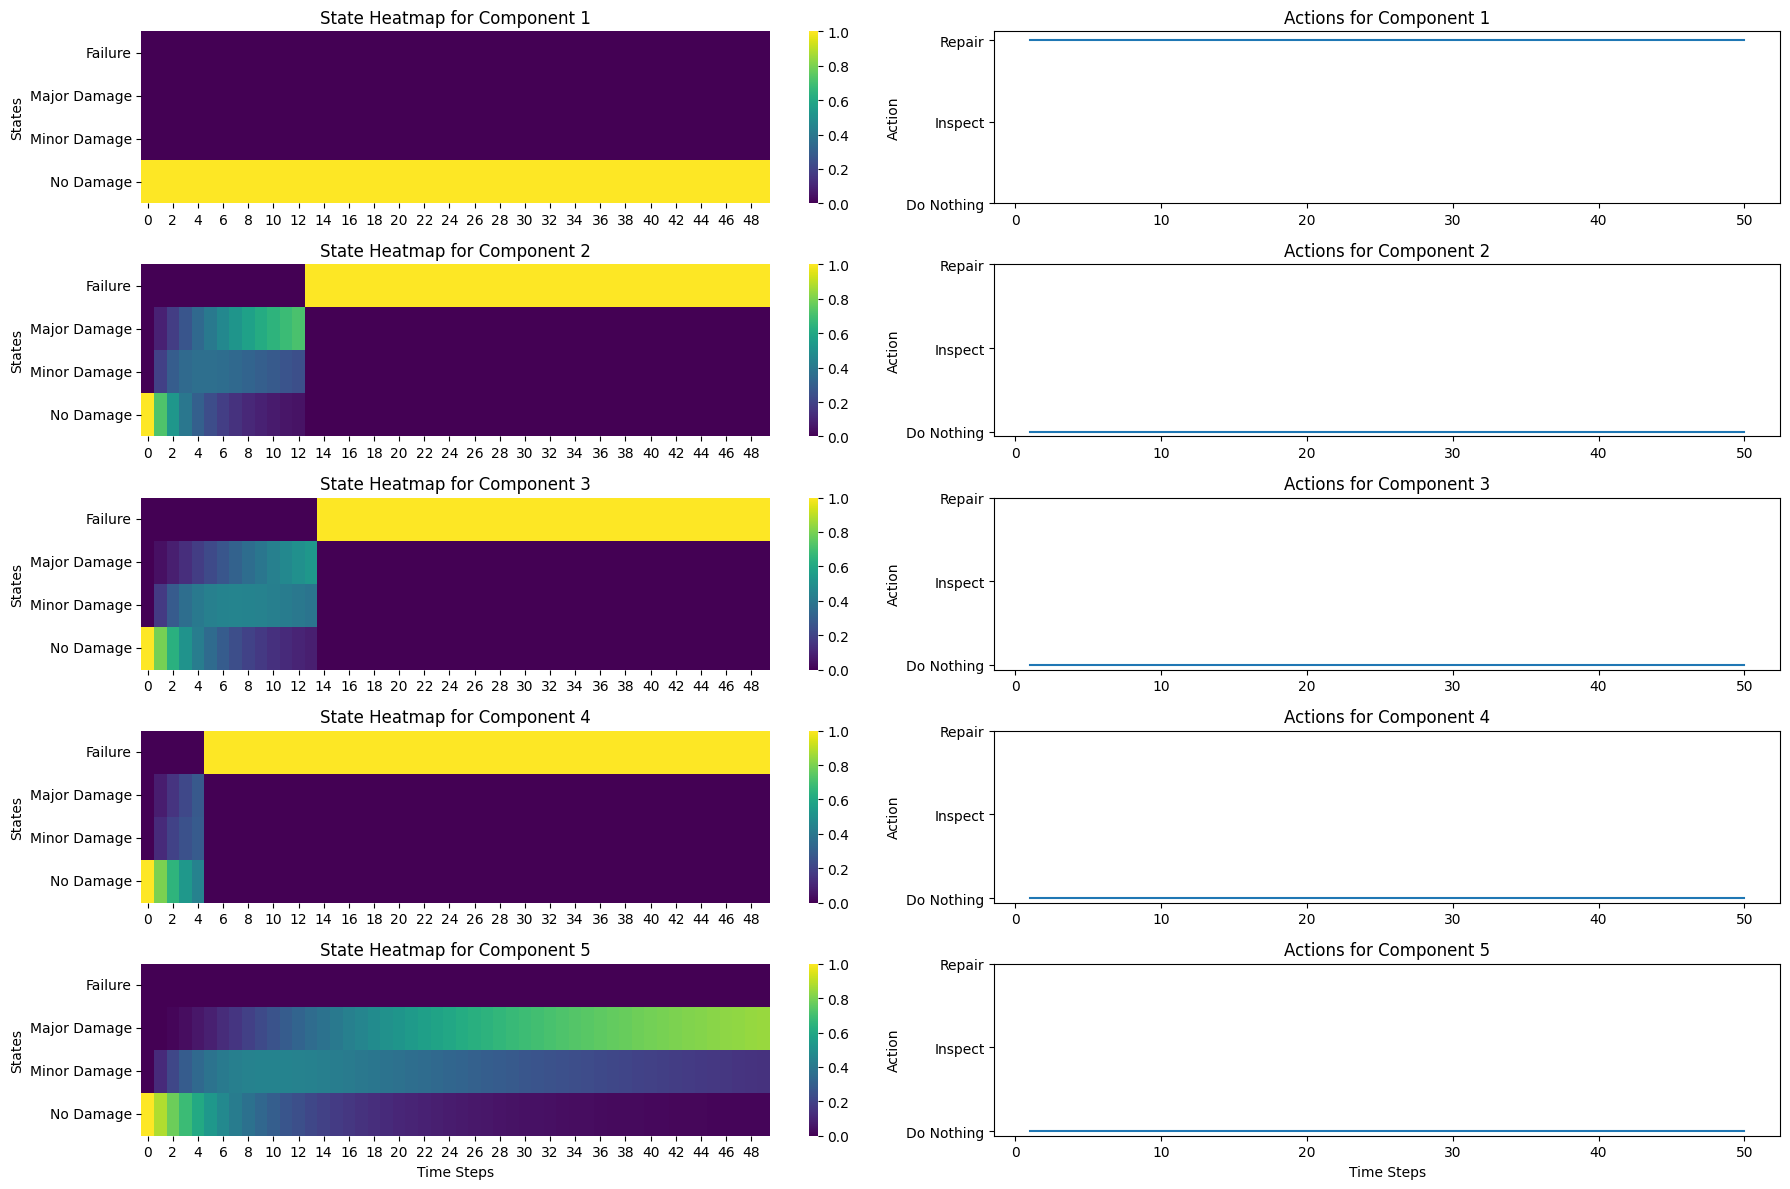

In [37]:
import seaborn as sns
fig, axes = plt.subplots(ncomp, 2, figsize=(18, 12), gridspec_kw={'width_ratios': [1, 1]})

if not isinstance(actions_, np.ndarray):
    actions_ = np.array(actions_)
if not isinstance(state_beliefs,np.ndarray):
    state_beliefs = np.array(state_beliefs)           
state_beliefs_squeezed = state_beliefs.squeeze(axis=(1, 4))
for i in range(ncomp):
    # Heatmap
    sns.heatmap(state_beliefs_squeezed[:, i, :].T, ax=axes[i, 0], cmap='viridis',  # Time steps (1-50)
                yticklabels=['No Damage', 'Minor Damage', 'Major Damage', 'Failure'])
    
    # Set titles and labels for heatmap
    axes[i, 0].set_title(f'State Heatmap for Component {i + 1}')
    axes[i, 0].set_ylabel('States')
    axes[i, 0].invert_yaxis()  # Invert y-axis to have state 1 at the bottom
    y_tick_labels = ['Do Nothing', 'Inspect', 'Repair']
    # Action plot
    axes[i, 1].plot(range(1, 51), actions_[:, :, i])
    axes[i, 1].set_title(f'Actions for Component {i + 1}')
    axes[i, 1].set_ylabel('Action')
    axes[i, 1].set_yticks(range(len(y_tick_labels)))  # Set y-ticks to [0, 1, 2]
    axes[i, 1].set_yticklabels(y_tick_labels)  # Set custom y-tick labels
    axes[i, 1].grid(False)

# Set common labels for the x-axis
axes[-1, 0].set_xlabel('Time Steps')  # X-label for the first column
axes[-1, 1].set_xlabel('Time Steps')  # X-label for the second column
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()